# LSTM - Time Series Dataset

- 서울시 기후 데이터 2011년 1월 1일 ~ 2019년 12월 31일

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

## 1) file upload

In [2]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'

temp = pd.read_csv(url)
temp.head(3)

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3


## 2) Data Preprocessing

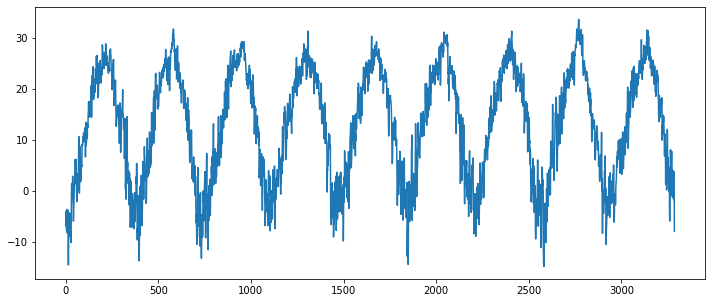

In [3]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

In [4]:
# Normalization & train,test split

scaler = MinMaxScaler(feature_range = (-1, 1))
temp_data = scaler.fit_transform(temp_data)

train = temp_data[0:2557]
test  = temp_data[2557:]

- 시계열 데이터 처리 함수

  X : 학습 평균온도 데이터
  y : 정답 평균온도 데이터
  
  일정 기간의 X로 y를 예측하도록 학습

In [5]:

def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

- look_back 기간 설정 후 학습데이터 생성

In [6]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

> ## Tensor Reshape

In [7]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

#  Bidirectional LSTM Modeling

In [8]:
model = Sequential(name ='Bidirectional_LSTM')
model.add(Bidirectional(LSTM(64, input_shape=(None,1))))
model.add(Dense(1,activation='tanh'))

In [9]:
# model compile

model.compile(loss='mean_squared_error',
              optimizer = 'adam')

%time
hist = model.fit(train_X, train_y,
                 epochs = 200,
                 batch_size = 16,
                 validation_data=(test_X,test_y))



CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs
Epoch 1/200
149/149 [==============================] - 36s 20ms/step - loss: 0.0334 - val_loss: 0.0158
Epoch 2/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0157 - val_loss: 0.0137
Epoch 3/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0149 - val_loss: 0.0119
Epoch 4/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0129 - val_loss: 0.0107
Epoch 5/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0108 - val_loss: 0.0091
Epoch 6/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0094 - val_loss: 0.0081
Epoch 7/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 8/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 9/200
149/149 [==============================] - 2s 14ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 10/200


In [21]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

In [ ]:
trainScore = model.evaluate(train_X, train_y, verbose=0)
print('Train_Score : ',trainScore)
testScore = model.evaluate(test_X,test_y, verbose = 0)
print('Test_Score : ', testScore)

# Predict

In [ ]:
look_ahead = 550
xhat = test_X[0]

predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size =1)
  predictions[i] = prediction
  xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12,5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()